# Unmasking the Web of Deceit: An Analysis of Online Payment Fraud

## Overview
Lorem ipsum dolor sit amet

## Setup

### Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import os.path
import zipfile
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Import Dataset

In [2]:
# Authenticate with your Kaggle credentials
api = KaggleApi()
api.authenticate()

# Specify the dataset name
dataset_name = 'online-payments-fraud-detection-dataset'
dataset_folder_path = './data/'
kaggle_dataset_path = 'rupakroy/' + dataset_name

if os.path.isfile(dataset_folder_path + dataset_name + '.csv'):
    print("Found dataset archive.")
else:
    # Download the dataset files
    print("Downloading dataset from Kaggle.")
    api.dataset_download_files(kaggle_dataset_path, path=dataset_folder_path, unzip=True)
    # Specify the path to the zip file
    zip_file_path = dataset_folder_path + dataset_name + '.zip'

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(dataset_folder_path)

    # Delete the zip file
    os.remove(zip_file_path)
    for filename in zip_ref.namelist():
        new_filename = dataset_name + '.csv'
        old_filepath = os.path.join(dataset_folder_path, filename)
        new_filepath = os.path.join(dataset_folder_path, new_filename)
        os.rename(old_filepath, new_filepath)
    print("Downloaded dataset from Kaggle.")

df = pd.read_csv(dataset_folder_path + dataset_name + '.csv')
# ake a copy to preserve the original data
dff = df.copy()

Found dataset archive.


## Data Preprocessing

### Check for empty data

In [3]:
if dff.isnull().values.any():
    print("Error: Missing data")
else:
    print("No missing values found.")

No missing values found.


### Rename Columns

In [4]:
dff.columns = ['Transaction_Hours','Type','Transaction_Amount','Sender','Sender_Balance_Previous_Transaction','Sender_Balance_After_Transaction','Receiver','Receiver_Balance_Previous_Transaction','Receiver_Balance_After_Transaction','Is_Fraud', 'Is_Flagged_Fraud']
print(dff.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Transaction_Hours                      int64  
 1   Type                                   object 
 2   Transaction_Amount                     float64
 3   Sender                                 object 
 4   Sender_Balance_Previous_Transaction    float64
 5   Sender_Balance_After_Transaction       float64
 6   Receiver                               object 
 7   Receiver_Balance_Previous_Transaction  float64
 8   Receiver_Balance_After_Transaction     float64
 9   Is_Fraud                               int64  
 10  Is_Flagged_Fraud                       int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


### Drop irrelevant columns

In [5]:
dff = dff.drop('Sender', axis=1)
dff = dff.drop('Receiver', axis=1)
dff = dff.drop('Is_Flagged_Fraud', axis=1)

dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Transaction_Hours                      int64  
 1   Type                                   object 
 2   Transaction_Amount                     float64
 3   Sender_Balance_Previous_Transaction    float64
 4   Sender_Balance_After_Transaction       float64
 5   Receiver_Balance_Previous_Transaction  float64
 6   Receiver_Balance_After_Transaction     float64
 7   Is_Fraud                               int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


### Check for correct data types

In [6]:
# Print datatypes of features to ensure they are the correct type
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Transaction_Hours                      int64  
 1   Type                                   object 
 2   Transaction_Amount                     float64
 3   Sender_Balance_Previous_Transaction    float64
 4   Sender_Balance_After_Transaction       float64
 5   Receiver_Balance_Previous_Transaction  float64
 6   Receiver_Balance_After_Transaction     float64
 7   Is_Fraud                               int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


### Convert Categorical Features to Numeric
One-hot encoding: This creates a new binary column for each category and is appropriate for nominal variables without an intrinsic order.

In [7]:

# Assuming 'df' is your DataFrame
categorical_columns = dff.select_dtypes(include=['object', 'category']).columns

# One-hot encoding: This creates a new binary column for each category and is appropriate for nominal variables without an intrinsic order.
dff = pd.get_dummies(dff, columns=categorical_columns, drop_first=True)

dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Transaction_Hours                      int64  
 1   Transaction_Amount                     float64
 2   Sender_Balance_Previous_Transaction    float64
 3   Sender_Balance_After_Transaction       float64
 4   Receiver_Balance_Previous_Transaction  float64
 5   Receiver_Balance_After_Transaction     float64
 6   Is_Fraud                               int64  
 7   Type_CASH_OUT                          bool   
 8   Type_DEBIT                             bool   
 9   Type_PAYMENT                           bool   
 10  Type_TRANSFER                          bool   
dtypes: bool(4), float64(5), int64(2)
memory usage: 364.1 MB


### Update Is_Fraud to Bool

In [8]:
# Assuming 'dff' is your DataFrame and 'isFraud' is a column with int64 type containing 0s and 1s
dff['Is_Fraud'] = dff['Is_Fraud'].astype(bool)
# Check the updated data type
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Transaction_Hours                      int64  
 1   Transaction_Amount                     float64
 2   Sender_Balance_Previous_Transaction    float64
 3   Sender_Balance_After_Transaction       float64
 4   Receiver_Balance_Previous_Transaction  float64
 5   Receiver_Balance_After_Transaction     float64
 6   Is_Fraud                               bool   
 7   Type_CASH_OUT                          bool   
 8   Type_DEBIT                             bool   
 9   Type_PAYMENT                           bool   
 10  Type_TRANSFER                          bool   
dtypes: bool(5), float64(5), int64(1)
memory usage: 321.6 MB


### Check for skewed distributions

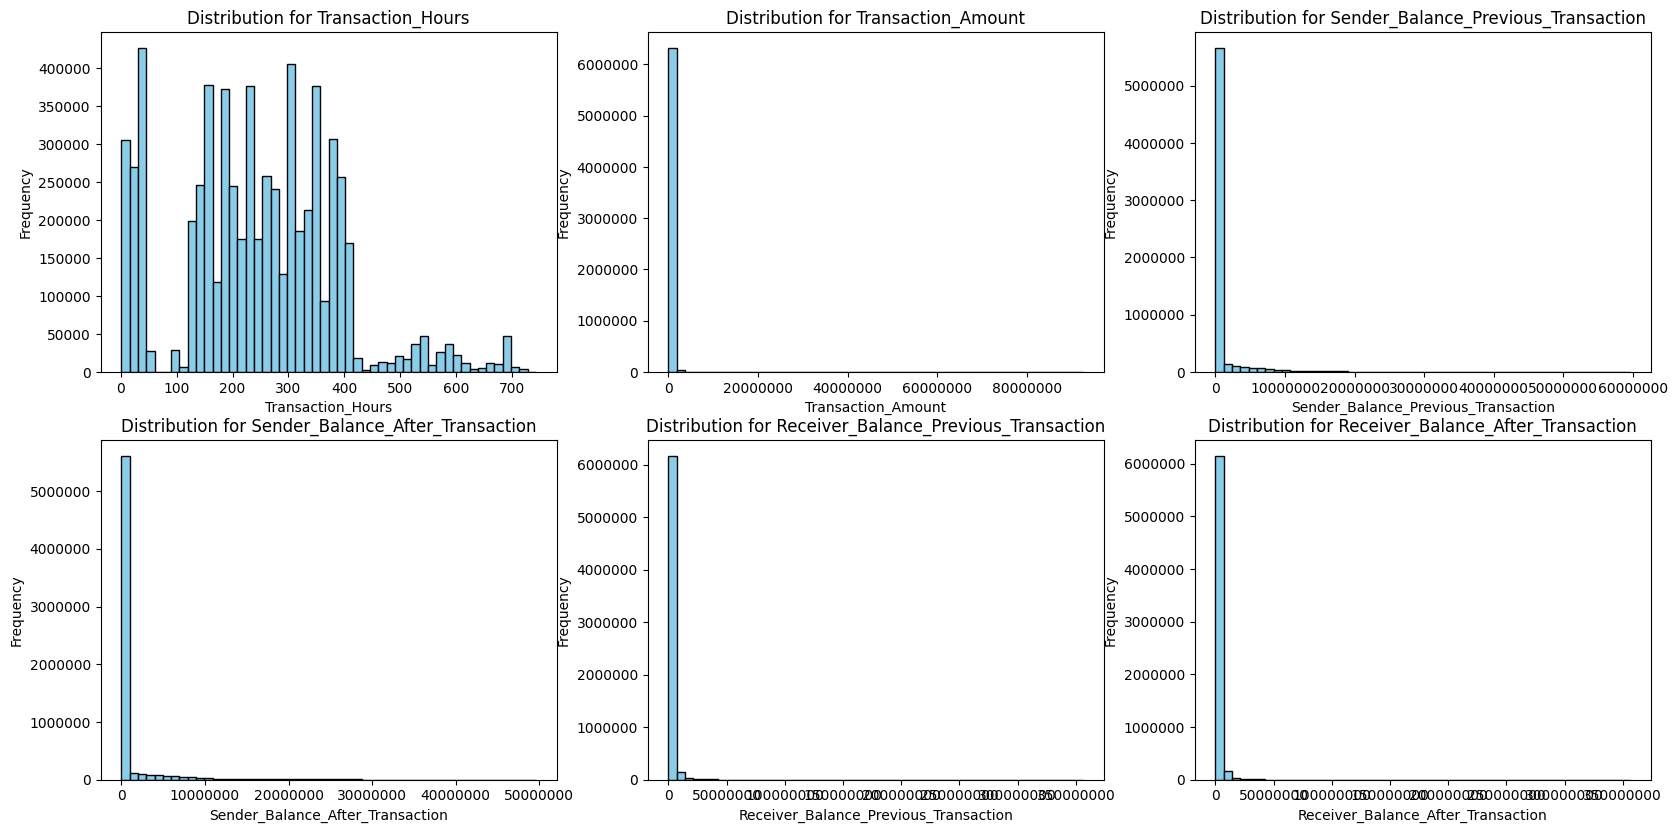

In [9]:
plt.figure(figsize=(20,15))

numerical_features = dff.select_dtypes(include=['int64', 'float64']).columns

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(numerical_features, 1):
    # plt.figure(figsize=(10, 6))
    plt.subplot(3, 3, i)
    plt.hist(dff[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

plt.show()


### Remove outliers

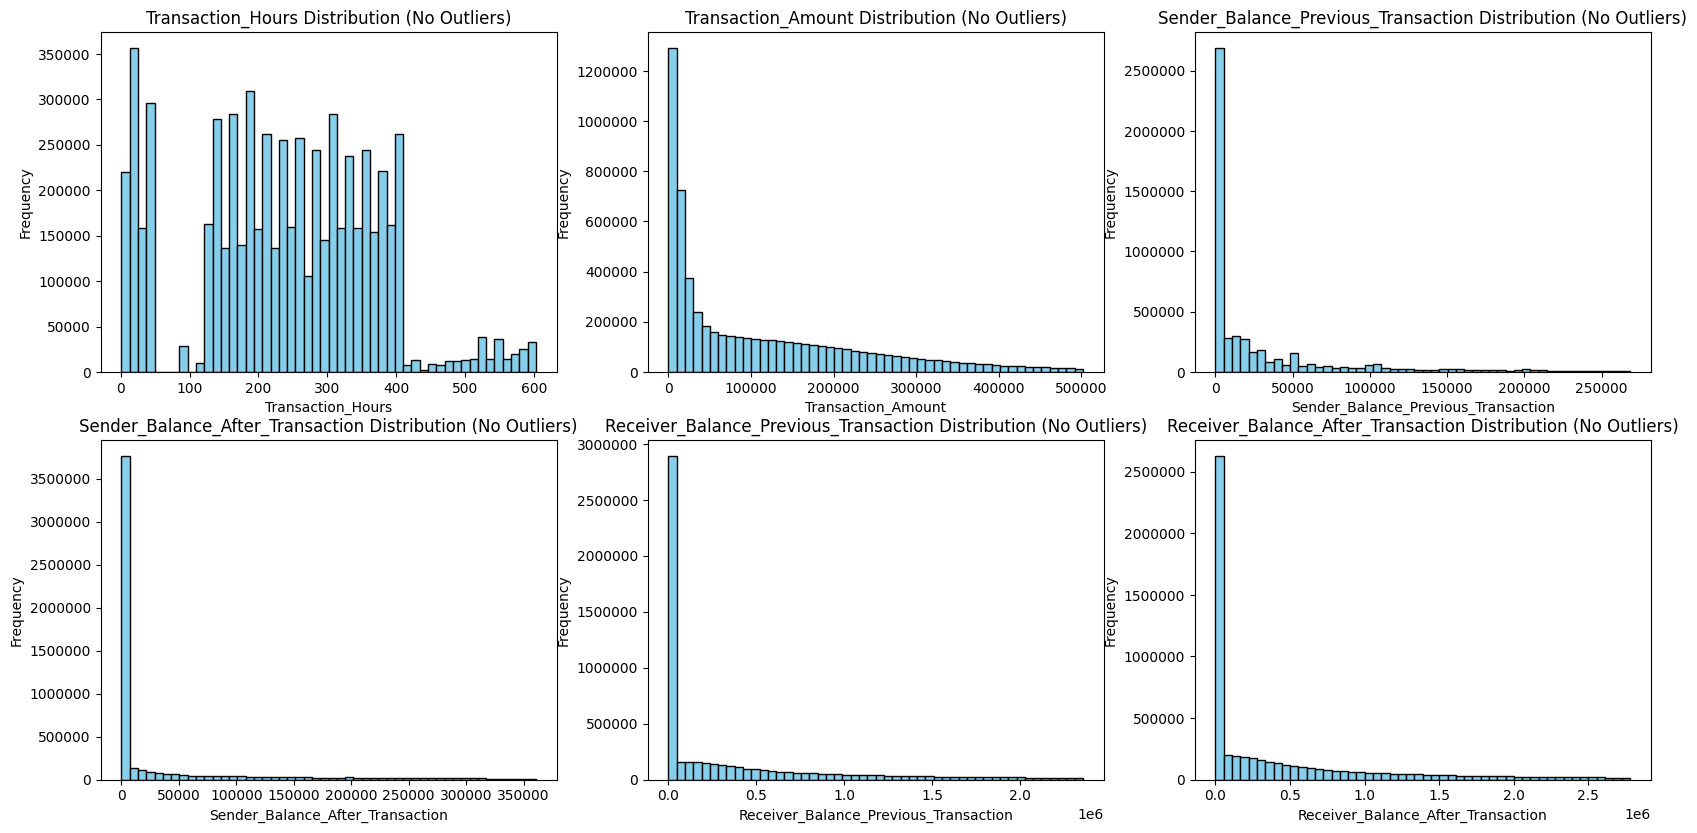

In [31]:
plt.figure(figsize=(20,15))

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(numerical_features, 1):
    # Calculate the IQR
    Q1 = dff[feature].quantile(0.25)
    Q3 = dff[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and filter out outliers
    df_no_outliers = dff[(dff[feature] >= lower_bound) & (dff[feature] <= upper_bound)]

    # Plot histogram of Transaction Amount after removing outliers
    plt.subplot(3, 3, i)
    plt.hist(df_no_outliers[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{feature} Distribution (No Outliers)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='y')

plt.show()


### Check for Class Imbalance

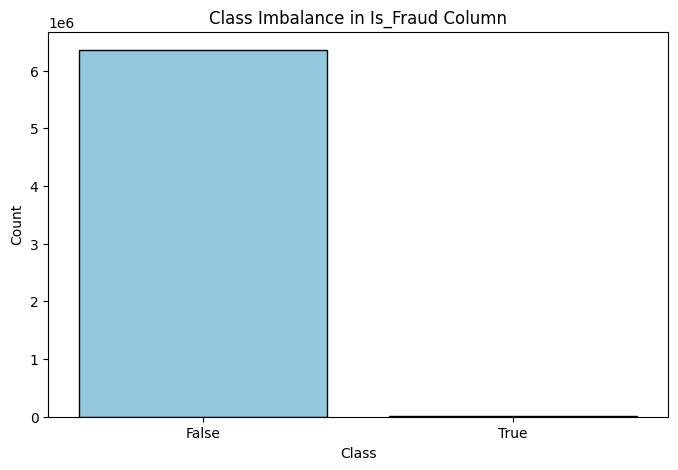

In [19]:
target = dff['Is_Fraud']

plt.figure(figsize=(8, 5))

# Plot the class imbalance
sns.countplot(x=target, hue=target, palette=["skyblue", "coral"], legend=False, edgecolor='black')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance in Is_Fraud Column')

plt.show()

### Undersample data

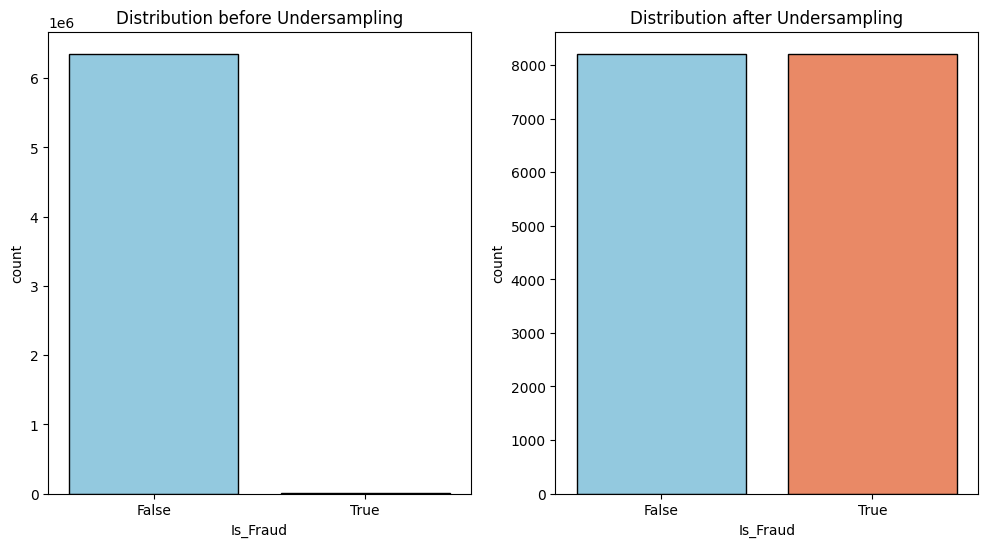

In [28]:
# Perform undersampling on the majority class
features = dff.drop('Is_Fraud', axis=1)
target = dff['Is_Fraud']

undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
features_undersampled, target_undersampled = undersampler.fit_resample(features, target)

# Plot the distribution before and after undersampling
plt.figure(figsize=(12, 6))

# Plot the distribution before undersampling
plt.subplot(1, 2, 1)
sns.countplot(x=target, hue=target, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution before Undersampling')

# Plot the distribution after undersampling
plt.subplot(1, 2, 2)
sns.countplot(x=target_undersampled, hue=target_undersampled, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution after Undersampling')

plt.show()


### Oversample the data

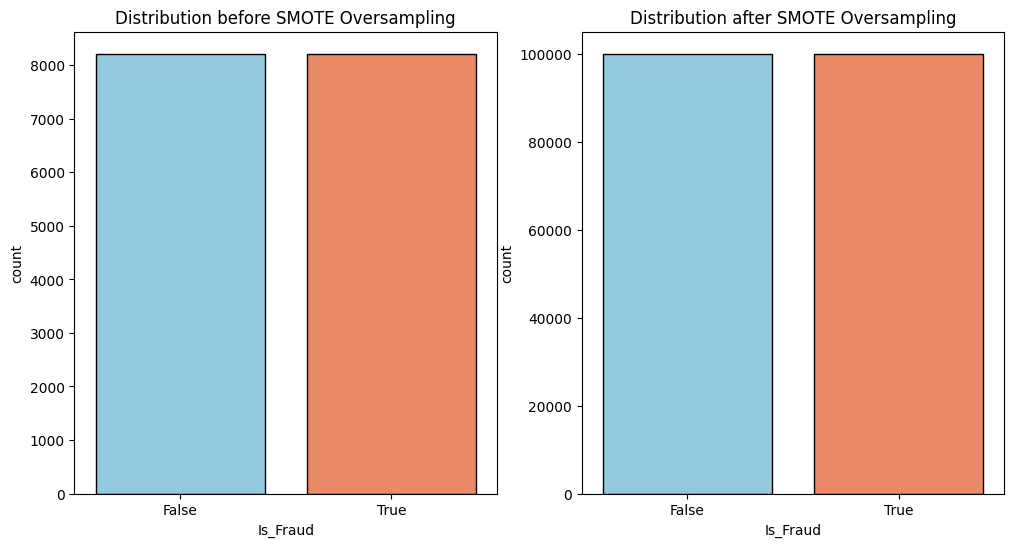

Number of samples per class after SMOTE:
Is_Fraud
False    100000
True     100000
Name: count, dtype: int64


In [27]:
# Set the desired samples for each class to 100,000
desired_samples = 100000

sampling_strategy = {0: desired_samples, 1: desired_samples}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
features_oversampled_smote, target_oversampled_smote = smote.fit_resample(features_undersampled, target_undersampled)

# Plot the distribution before and after SMOTE oversampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=target_undersampled, hue=target_undersampled, palette=["skyblue", "coral"], legend=False, edgecolor='black')

plt.title('Distribution before SMOTE Oversampling')

plt.subplot(1, 2, 2)
sns.countplot(x=target_oversampled_smote,  hue=target_oversampled_smote, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution after SMOTE Oversampling')

plt.show()


### Split Data
Use stratify to keep even distribution between sets of class data

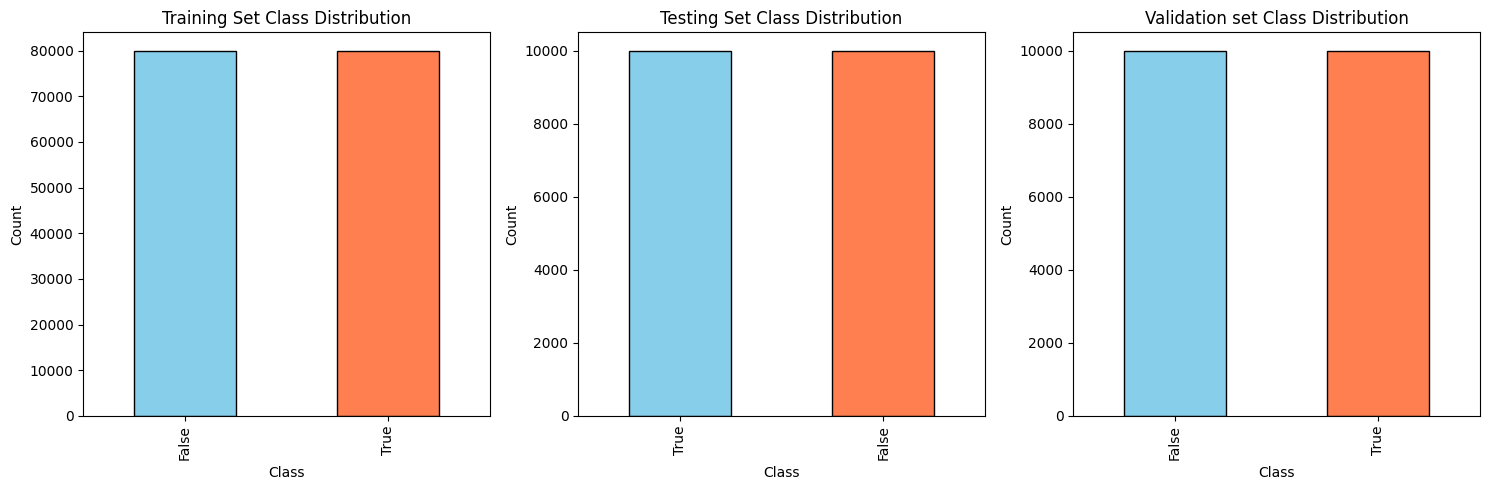

In [26]:
# Split the resampled data into training, validation, and two testing sets (80/10/10 split)
X_train, X_temp, y_train, y_temp = train_test_split(features_oversampled_smote, target_oversampled_smote, test_size=0.2, random_state=42, stratify=target_oversampled_smote)
X_validation, X_test, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Plot the class distribution of all three sets
plt.figure(figsize=(15, 5))

# Training Set Class Distribution
plt.subplot(1, 3, 1)
pd.Series(y_train).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Testing Set Class Distribution
plt.subplot(1, 3, 2)
pd.Series(y_test).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Testing Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Validation Set Class Distribution
plt.subplot(1, 3, 3)
pd.Series(y_validation).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Validation set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
